
## 1）Binary Encoding  
## 2）One Hot Encoding  
## 3）Standarization  
## 4）Polynimial 

There are four method to extract feature,  
though 1,2,3 is not that effective since we use tree-based model

### 在Construct MODEL without any processing.ipynb中
### 將train test 轉成乾淨的狀態並輸出名為train2,test2的CSV檔
### 故此檔案將會呼叫train2,test2

In [1]:
import os
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from xgboost import XGBClassifier


train = pd.read_csv('train2.csv',encoding = 'big5')
test = pd.read_csv('test2.csv',encoding = 'big5')


In [2]:
train.head()

,CUS_ID,EDUCATION_CD,MARRIAGE_CD,L1YR_A_ISSUE_CNT,L1YR_B_ISSUE_CNT,CHANNEL_A_POL_CNT,CHANNEL_B_POL_CNT,OCCUPATION_CLASS_CD,APC_CNT,INSD_CNT,...,IF_ADD_INSD_IND,CUST_9_SEGMENTS_CD,FINANCETOOLS_A,FINANCETOOLS_B,FINANCETOOLS_C,FINANCETOOLS_D,FINANCETOOLS_E,FINANCETOOLS_F,FINANCETOOLS_G,Y1
0,3418,3.0,0.0,0,0,0,0,1.0,0,0,...,0,2,1,0,0,0,0,0,0,0
1,4302,3.0,0.0,0,0,0,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,5545,1.0,0.0,1,0,1,0,1.0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,7207,3.0,0.0,0,0,0,0,1.0,0,0,...,0,2,1,0,0,0,0,0,0,0
4,7213,1.0,0.0,0,0,1,0,1.0,1,0,...,0,2,1,0,0,0,0,0,0,0


### Normalization

In [15]:
from sklearn.preprocessing import Normalizer

for col in train.columns:
    if train[col].unique().sum()>10 and col!='CUS_ID':
        x = np.array(train[col]).reshape(-1,1)
        train[col] = Normalizer(norm='l1').fit_transform(x)


### Binary Encoding

In [3]:
# Binary Encoding 衍生新的欄位，把低於80%的資料視為1，其餘視為0
def derivative(df, var_name):
    derivative_name = 'RANK_' + var_name
    standard = np.percentile(df[var_name] , [80])[0] # 以整體數據
    df[derivative_name] = df[var_name].apply(lambda x : 1 if x>standard else 0)

In [ ]:
#對年繳化保費衍伸出新的欄位
val_counts = df[df['ANNUAL_PREMIUM_AMT']>0.01]
df['RANK_ANNUAL_PREMIUM_AMT'] = pd.cut(df['ANNUAL_PREMIUM_AMT'],[-2,-0.0001 ,0.01,1])
df['RANK_ANNUAL_PREMIUM_AMT']

In [4]:
train.nunique()

CUS_ID              100000
EDUCATION_CD             4
MARRIAGE_CD              3
L1YR_A_ISSUE_CNT        17
L1YR_B_ISSUE_CNT         5
                     ...  
FINANCETOOLS_D           2
FINANCETOOLS_E           2
FINANCETOOLS_F           2
FINANCETOOLS_G           2
Y1                       2
Length: 132, dtype: int64

### Polynomial

In [4]:
continuous = []
for col in train.columns:
    if train[col].unique().sum()>10 and col!='CUS_ID':
        continuous.append(col)

In [5]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=False, include_bias = False)

poly_train = poly.fit_transform(train[continuous])
poly_train = pd.DataFrame(poly_train)

poly_test = poly.fit_transform(test[continuous])
poly_test = pd.DataFrame(poly_test)

In [6]:
poly_train

,0,1,2,3,4,5,6,7,8,9,...,619,620,621,622,623,624,625,626,627,628
0,0.0,0.0,0.0,1.0,0.0,0.046512,3.0,3.0,0.000192,1.0,...,3.032335e-08,0.000000,0.000000,0.000348,0.0,0.0,0.0,0.0,0.0,4.0
1,0.0,0.0,0.0,1.0,0.0,0.046512,5.0,3.0,0.009675,1.0,...,7.611655e-05,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.000000,5.0,3.0,0.000292,1.0,...,2.871994e-05,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.162791,5.0,3.0,0.000000,1.0,...,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4.0
4,0.0,1.0,0.0,1.0,0.0,0.116279,2.0,3.0,0.000664,1.0,...,3.633932e-07,0.000000,0.000000,0.001206,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,3.0,0.0,1.0,2.0,0.372093,1.0,7.0,0.000483,2.0,...,1.926841e-07,0.000000,0.000000,0.002634,0.0,0.0,0.0,0.0,0.0,36.0
99996,0.0,1.0,0.0,1.0,1.0,0.465116,5.0,3.0,0.000000,1.0,...,0.000000e+00,0.000000,0.000000,0.000000,49.0,49.0,49.0,49.0,49.0,49.0
99997,0.0,4.0,0.0,1.0,1.0,0.279070,5.0,8.0,0.000000,3.0,...,0.000000e+00,0.000000,0.000000,0.000000,25.0,25.0,35.0,25.0,35.0,49.0
99998,0.0,2.0,0.0,1.0,2.0,0.023256,4.0,5.0,0.000548,1.0,...,2.537913e-07,0.000000,0.000000,0.003023,0.0,0.0,0.0,0.0,0.0,36.0


In [7]:
# concat polynomail numeric and object
poly_train_OHE = pd.concat([train.drop(continuous, axis = 1),poly_train],axis = 1)
poly_test_OHE = pd.concat([test.drop(continuous, axis = 1),poly_test],axis = 1)

In [8]:
poly_train_OHE.shape

(100000, 727)

In [9]:
poly_test_OHE.shape

(150000, 726)

### Let's put poly_train_OHE into model and see whether ROC_AUC would lift or not

In [10]:
from sklearn.model_selection import train_test_split
X = poly_train_OHE.drop(columns = ['Y1'])
y = poly_train_OHE['Y1']
X_train, X_test, y_train, y_test = train_test_split(X , y,test_size=0.25, random_state=33)
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
y_pred = xgbc.predict(X_test)
ROC_AUC = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', ROC_AUC)



ROC_AUC = : 0.5010118568592736


(2.0, 0.0)

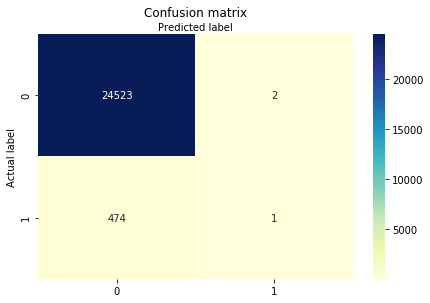

In [11]:
from sklearn import metrics
import seaborn as sns

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

### The result is frustrated , try other feature engineering measure

### How about using SMOTETomek to enlarge the influence of minority

In [12]:
#Apply SMOTE to create synthetic observations from minority class
#Source:https://github.com/scikit-learn-contrib/imbalanced-learn
from imblearn.combine import  SMOTETomek #Over sampling
X = train.drop(columns = ['Y1'])
y = train['Y1']
X_resample,y_resample  = SMOTETomek().fit_sample(X, y)
X_resample = pd.concat([X_resample,y_resample],axis = 1)


print('Total rows in original data:{}'.format(train.shape[0]))


print('Percentage of buying insurance in  original data',len(np.where(y==1)[0]) / len(y))

print('-'*100)
print('Total rows in resample data :{}'.format(X_resample.shape[0]))


print('Percentage of buying insurance after oversampling',len(np.where(y_resample==1)[0]) / len(y_resample))

Using TensorFlow backend.


Total rows in original data:100000
Percentage of buying insurance in  original data 0.02
----------------------------------------------------------------------------------------------------
Total rows in resample data :165242
Percentage of buying insurance after oversampling 0.5


### Visuallize the difference before and after oversampling

Text(0.5, 1.0, 'SMOTE + Tomek')

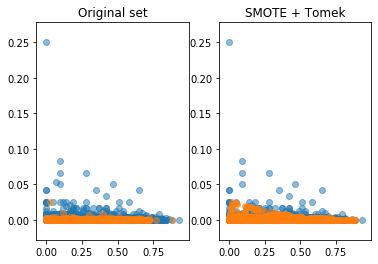

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(train[train['Y1']==0]['APC_1ST_YEARDIF'],train[train['Y1']==0]['ANNUAL_INCOME_AMT'],
                 label="Class #0",alpha=0.5)
ax1.scatter(train[train['Y1']==1]['APC_1ST_YEARDIF'],train[train['Y1']==1]['ANNUAL_INCOME_AMT'],
                 label="Class #1",alpha=0.5)
ax1.set_title('Original set')


ax2.scatter(X_resample[X_resample['Y1']==0]['APC_1ST_YEARDIF'],X_resample[X_resample['Y1']==0]['ANNUAL_INCOME_AMT'],
                 label="Class #0",alpha=0.5)
ax2.scatter(X_resample[X_resample['Y1']==1]['APC_1ST_YEARDIF'],X_resample[X_resample['Y1']==1]['ANNUAL_INCOME_AMT'],
                 label="Class #1",alpha=0.5)

ax2.set_title('SMOTE + Tomek')

### To test whether the ROC_AUC lift after oversampling

In [31]:
from sklearn.model_selection import train_test_split
X = X_resample.drop(columns = ['Y1','CUS_ID'])
y = y_resample
X_train, X_test, y_train, y_test = train_test_split(X , y,test_size=0.25, random_state=33)
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
y_pred = xgbc.predict(X_test)
ROC_AUC = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', ROC_AUC)



ROC_AUC = : 0.9814421447853092


### Draw confusion matrix 

(2.0, 0.0)

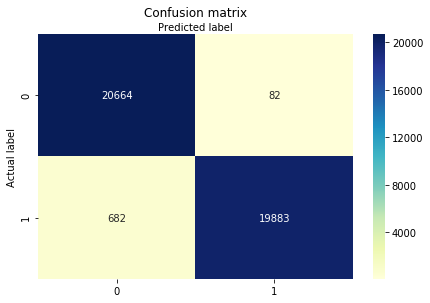

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

#### The result is impossible high, there must be something wrong

### Train with oversampling data , test with original data

ROC_AUC = : 0.5244795918367346


(2.0, 0.0)

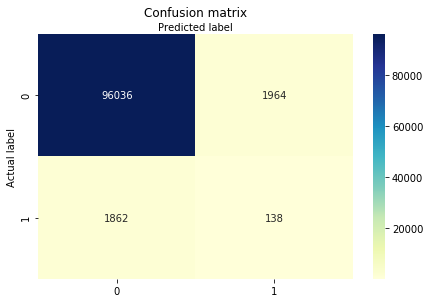

In [43]:
y_pred = xgbc.predict(train.drop(columns = ['Y1','CUS_ID']))
y_test = train['Y1']
score = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', score)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

### The result has advamced yet still need to be improved, that's think about other solution !


### SMOTEENN (Undersampling)

In [50]:
from imblearn.combine import SMOTEENN

In [51]:
smote_enn = SMOTEENN(random_state=0)
X_resample, y_resample = smote_enn.fit_resample(train.drop(columns = ['Y1']), train['Y1'])
X_resample = pd.concat([X_resample,y_resample],axis = 1)


In [70]:
# there are 30116 of 0 and 32287 of 1
np.unique(y_resampled, return_counts=True)

(array([0, 1]), array([30116, 32287]))

In [60]:
from sklearn.model_selection import train_test_split
X = X_resample.drop(columns = ['Y1','CUS_ID'])
y = y_resample
X_train, X_test, y_train, y_test = train_test_split(X , y,test_size=0.25, random_state=33)
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score
y_pred = xgbc.predict(X_test)
ROC_AUC = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', ROC_AUC)



ROC_AUC = : 0.984579451814678


(2.0, 0.0)

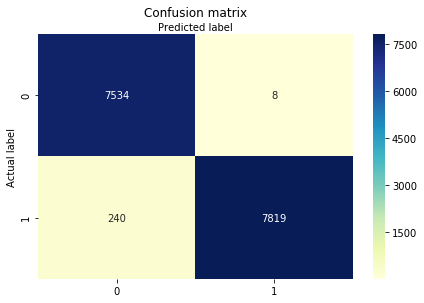

In [62]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

### Train with Undersampling data , test with original data

ROC_AUC = : 0.5062040816326531


(2.0, 0.0)

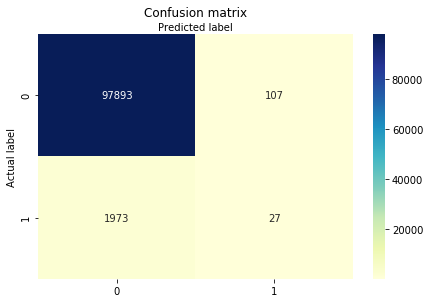

In [69]:
y_pred = xgbc.predict(train.drop(columns = ['Y1','CUS_ID']))
y_test = train['Y1']
score = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', score)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

### Undersampling yields with bad outcome

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_validate
from sklearn.model_selection import train_test_split

X = train.drop(columns = ['Y1','CUS_ID'])
y = train['Y1']
X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size=0.25, random_state=33)

y_pred = lr.predict(X_test)
ROC_AUC = roc_auc_score(y_test,y_pred)

In [71]:
from imblearn.combine import  SMOTETomek #Over sampling
X = train.drop(columns = ['Y1'])
y = train['Y1']
X_resample,y_resample  = SMOTETomek().fit_sample(X, y)
X_resample = pd.concat([X_resample,y_resample],axis = 1)

ROC_AUC = : 0.9424865644560507


/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(2.0, 0.0)

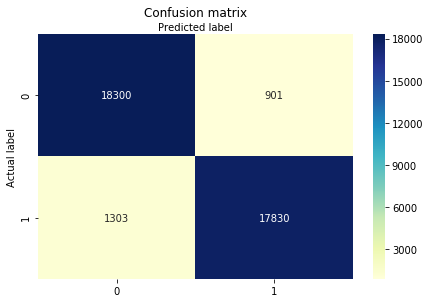

In [73]:
from sklearn.model_selection import train_test_split
X = X_resample.drop(columns = ['Y1','CUS_ID'])
y = y_resample
X_train, X_test, y_train, y_test = train_test_split(X , y,test_size=0.25, random_state=33)
lr = LogisticRegression(C = 0.01, penalty = 'l2')
lr.fit(X_train,y_train)


y_pred = lr.predict(X_test)
ROC_AUC = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', ROC_AUC)


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

ROC_AUC = : 0.5489489795918367


(2.0, 0.0)

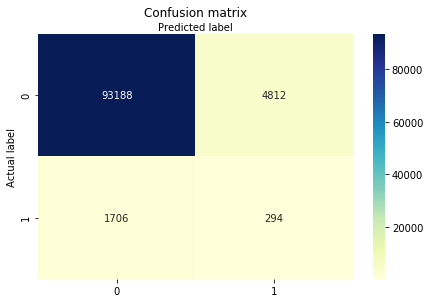

In [74]:
y_pred = lr.predict(train.drop(columns = ['Y1','CUS_ID']))
y_test = train['Y1']
score = roc_auc_score(y_test,y_pred)
print('ROC_AUC = :', score)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create confusion matrix
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout

### Logistic Regression is better among all classifier.

Lastly, we could apply K-Fold to assure the accuracy

In [108]:
import numpy as np
from sklearn.model_selection import KFold
X = train.drop(columns = ['Y1','CUS_ID'])
y = train['Y1']
kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    score = roc_auc_score(y_test,y_pred)
    print(score)
    

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [20000 20001 20002 ... 99997 99998 99999] TEST: [    0     1     2 ... 19997 19998 19999]
0.5
TRAIN: [    0     1     2 ... 99997 99998 99999] TEST: [20000 20001 20002 ... 39997 39998 39999]
0.5
TRAIN: [    0     1     2 ... 99997 99998 99999] TEST: [40000 40001 40002 ... 59997 59998 59999]
0.5
TRAIN: [    0     1     2 ... 99997 99998 99999] TEST: [60000 60001 60002 ... 79997 79998 79999]
0.5
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [80000 80001 80002 ... 99997 99998 99999]
0.5


Conclusion: It seems that training set will get fantastic score,  
but as applying to original data, it still overfitting